# Acoustic Anomaly Detection with Azure Machine Learning
## 5. Calling the Azure CV model

<img src="https://github.com/retkowsky/Audio_Analytics_With_AzureML/raw/main/image.jpg" width = 800>

<div class="alert alert-info"> <b>Let's predict an audio file using the Azure Custom Vision model that we have trained and deployed using www.customvision.ai</b></div>

Serge Retkowsky | serge.retkowsky@microsoft.com | 31-May-2022 | V2

In [1]:
#!pip install audio_metadata
#!pip install azure-cognitiveservices-vision-customvision
#!pip install emoji
#!pip install python-docx
#!pip install pymsteams

In [2]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [3]:
import datetime
print('Current Date: ' + str(datetime.datetime.today()))

Current Date: 2022-05-31 09:05:59.191589


In [4]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region

from msrest.authentication import ApiKeyCredentials
import os, time, uuid
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import emoji
import datetime
import docx
import pymsteams
import smtplib
from email.message import EmailMessage
import emoji
from configparser import ConfigParser
import plotly.graph_objects as go

## Calling Azure CustomVision deployed model

In [5]:
# Retrieving the Azure customvision.ai deployed model information from the azurecvconfig.ini file

configcv = ConfigParser()
print (configcv.read('azurecvconfig.ini'))
print("Section:", configcv.sections())

PREDICTION_KEY = configcv.get('azurecustomvision', 'PREDICTION_KEY')
ENDPOINT = configcv.get('azurecustomvision', 'ENDPOINT')
PROJECT_ID = configcv.get('azurecustomvision', 'PROJECT_ID')
ITERATION_NAME = configcv.get('azurecustomvision', 'ITERATION_NAME')

['azurecvconfig.ini']
Section: ['azurecustomvision']


In [6]:
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY })
predictor = CustomVisionPredictionClient(ENDPOINT, credentials)

In [7]:
def AudioMetadata(audiofile):
    
    import os.path
    import time
    import audio_metadata
    
    lastmodifdate = time.ctime(os.path.getmtime(audiofile))
    creationdate = time.ctime(os.path.getctime(audiofile))
    audiofilemetadata = audio_metadata.load(audiofile)
    
    bitrate = audiofilemetadata['streaminfo']['bitrate']
    nbchannels = audiofilemetadata['streaminfo']['channels']
    duration = audiofilemetadata['streaminfo']['duration']
    samplerate = audiofilemetadata['streaminfo']['sample_rate']
    audiofilesize = audiofilemetadata['filesize']
    
    print("--- Audio Statistics ---\n")
    print("Audio File:\t", audiofile)
    print("Modified Date:\t", lastmodifdate)
    print("Creation Date:\t", creationdate)
    print("File Size:\t", audiofilesize)

    print("Bit Rate:\t", bitrate)
    print("Sampling Rate:\t", samplerate)
    print("Nb of Channels:\t", nbchannels)
    print("Duration:\t", duration)
    print()
    
    return { 'audiofile' : audiofile , 'lastmodifdate' : lastmodifdate,  'creationdate' : creationdate ,
             'audiofilesize' : audiofilesize ,   
             'bitrate' : bitrate , 'samplerate' : samplerate,  'nbchannels' : nbchannels , 'duration' : duration }

In [8]:
def gauge_report(VALUE, MSG):
    
    fig = go.Figure(go.Indicator(
        mode = "number+gauge+delta", value = VALUE,
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text' : MSG},
        delta = {'reference': 0.5},
        gauge = {
            'shape': "bullet",
            'axis': {'range': [None, 1]},
            'bar' : {'color' : 'black', 'thickness' : 0.2 },
            'threshold': {'line': {'color': "blue", 'width': 4}, 'thickness': 1, 'value': 0.5},
            'steps': [
                {'range': [0, 0.5], 'color': "red"},
                {'range': [0.5, 0.6], 'color': "orange"},
                {'range': [0.6, 0.7], 'color': "mediumseagreen"},
                {'range': [0.7, 1], 'color': "green"}
            ]}))
    
    fig.update_layout(height = 250, width = 900)
    fig.show()

## Let's analyse a WAV audio file to predict its class

In [9]:
!ls test/*.* -lh

-rwxrwxrwx 1 root root 1.2M May 31  2022 test/machine_KO.wav
-rwxrwxrwx 1 root root 1.2M May 31  2022 test/machine_OK.wav


In [10]:
audiofile = 'test/machine_KO.wav'

In [11]:
AudioMetadata(audiofile)

--- Audio Statistics ---

Audio File:	 test/machine_KO.wav
Modified Date:	 Tue May 31 10:26:06 2022
Creation Date:	 Tue May 31 08:56:06 2022
File Size:	 1234844
Bit Rate:	 1411200
Sampling Rate:	 44100
Nb of Channels:	 2
Duration:	 7.0



{'audiofile': 'test/machine_KO.wav',
 'lastmodifdate': 'Tue May 31 10:26:06 2022',
 'creationdate': 'Tue May 31 08:56:06 2022',
 'audiofilesize': 1234844,
 'bitrate': 1411200,
 'samplerate': 44100,
 'nbchannels': 2,
 'duration': 7.0}

## Playing the sound file

In [12]:
print("File is:", audiofile)
from IPython.display import Audio
Audio(audiofile)

File is: test/machine_KO.wav


In [13]:
samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = 5)
len(samples), sampling_rate
duration = len(samples) / sampling_rate
print("Samping rate:", sampling_rate)

Samping rate: 44100


In [14]:
from librosa import display

plt.figure(figsize = (15, 7))
librosa.display.waveshow(y = samples, sr = sampling_rate)
plt.title('Waveplot')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
plt.savefig('results/signal.jpg')

In [15]:
y, sr = librosa.load(audiofile)
tempo, beat_frames = librosa.beat.beat_track(y = y, sr = sr)
print(tempo)

172.265625


## Periodogram

In [16]:
exportfile = 'test/spectogram.jpg'

In [17]:
durationsecs = 7
hoplength = 512
samprate = 44100
nfft = 2048

In [18]:
plt.figure(figsize = (15, 8))

y, sr = librosa.load(audiofile,  sr = None, mono = True, offset = 0.0, duration = durationsecs)
plt.ioff()
fig = plt.figure()
        
mel_signal = librosa.feature.melspectrogram(y = y, sr = sr, hop_length = hoplength, n_fft = nfft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref = np.max)
librosa.display.specshow(power_to_db, sr = sr, x_axis = 'time', y_axis = 'mel', 
                         cmap = 'magma', hop_length = hoplength)
        
plt.ioff()
#fig = plt.figure()
        
plt.axis('off')
plt.savefig(exportfile, dpi = 300)
plt.close('all')

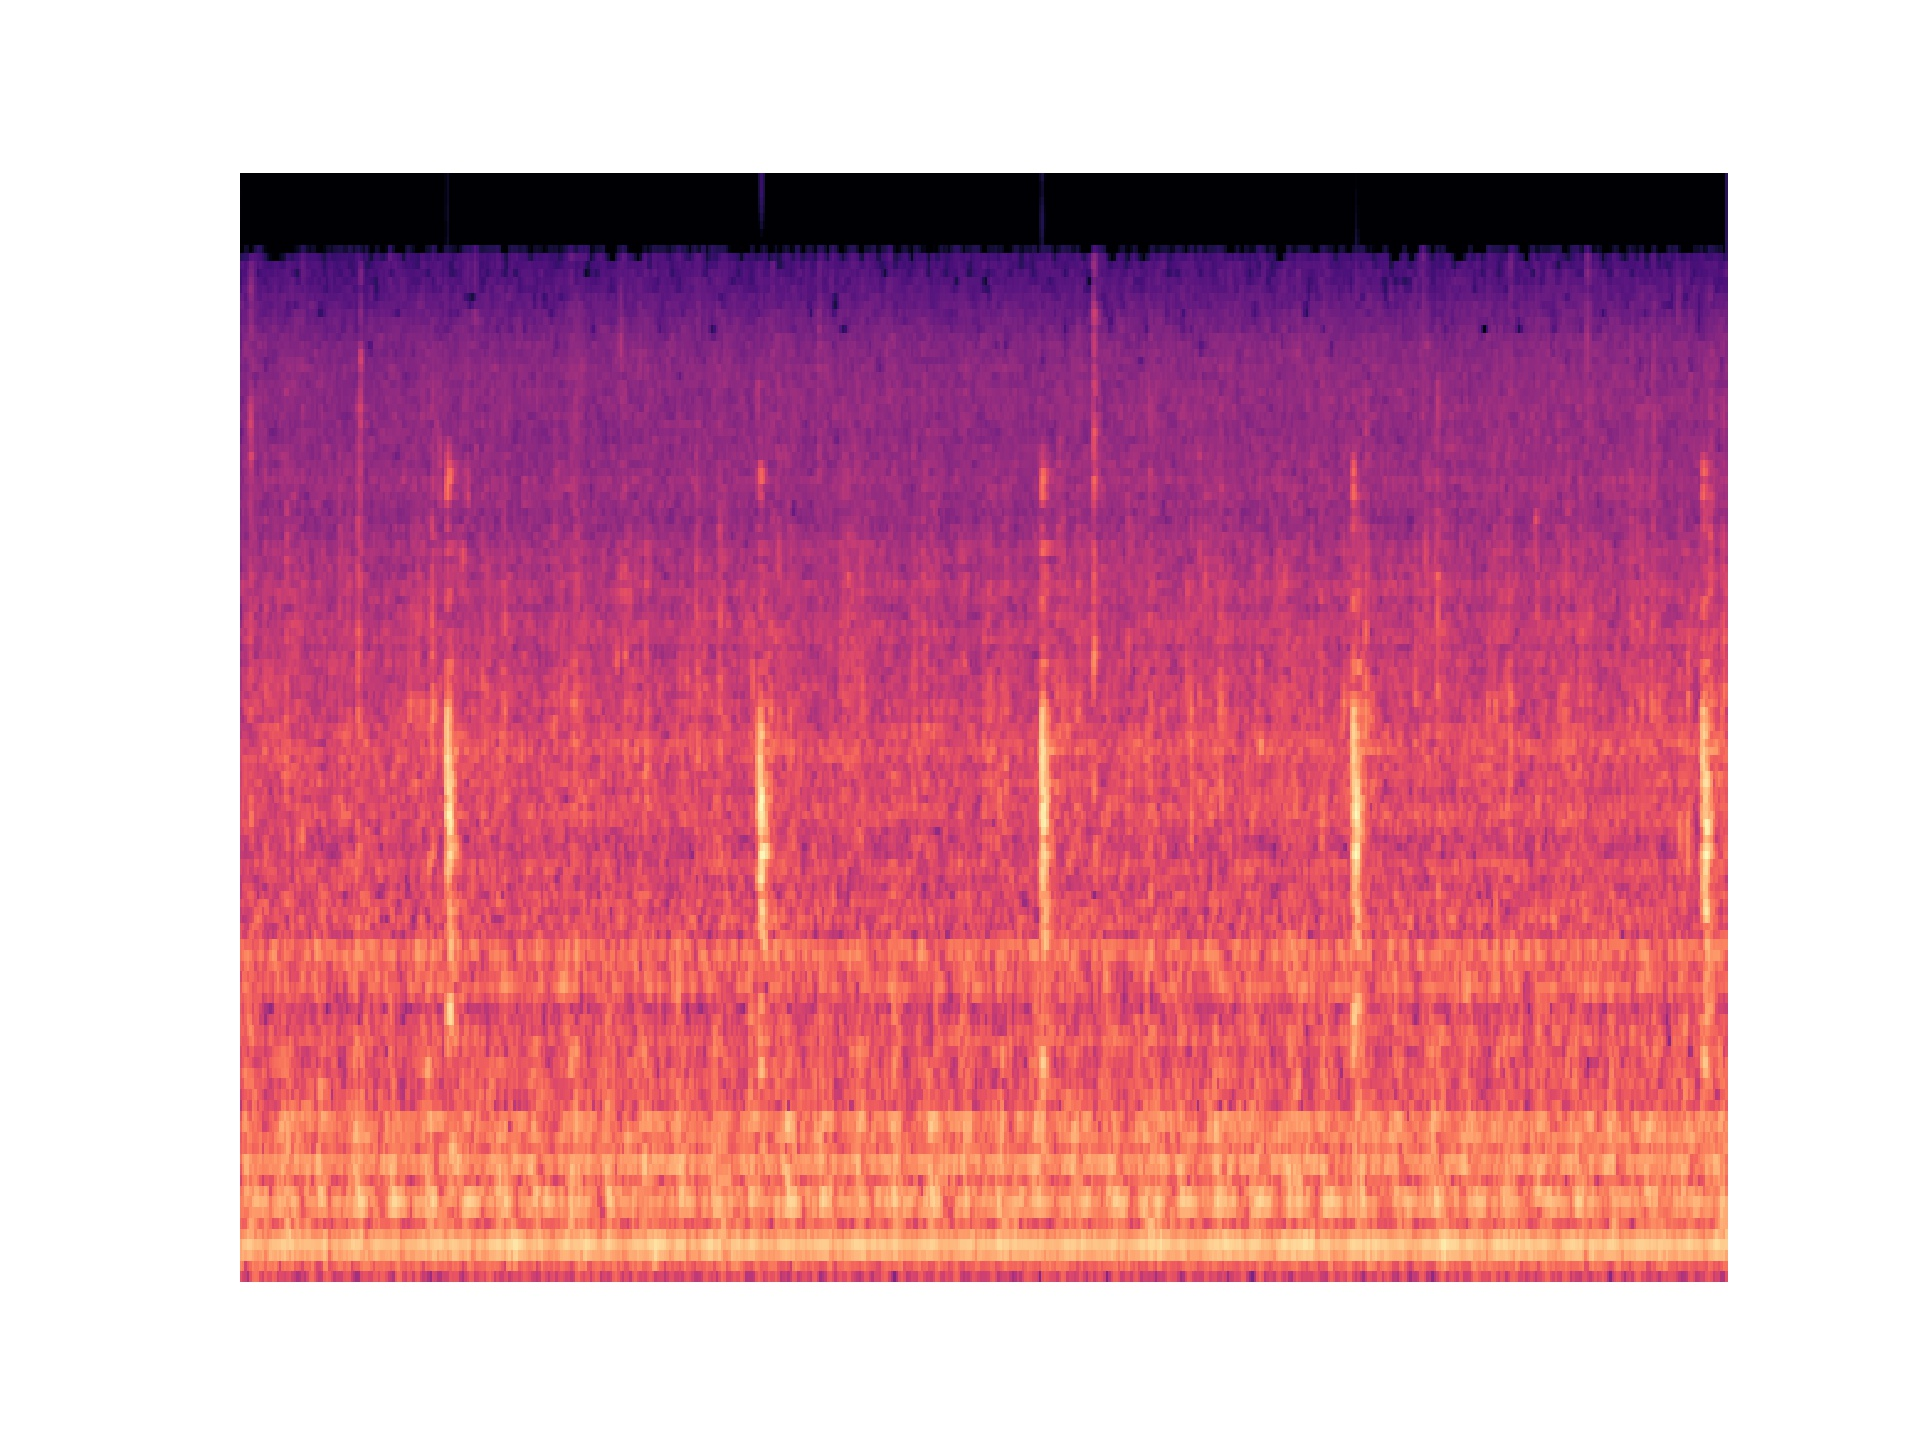

In [19]:
from IPython.display import Image
Image(filename = exportfile) 

## Calling the CV model

In [20]:
print("Prediction of", audiofile)

Prediction of test/machine_KO.wav


In [21]:
print(emoji.emojize("Calling the custom vision model to predict sound anomalies :thumbs_up:"))
print()
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

with open(os.path.join (exportfile), "rb") as image_contents:
    results = predictor.classify_image(PROJECT_ID, ITERATION_NAME , image_contents.read())

    for prediction in results.predictions:
        print("\033[1;31;34m-", prediction.tag_name, "\tConfidence =", round(prediction.probability, 5))

Calling the custom vision model to predict sound anomalies 👍

- KO 	Confidence = 0.99997
- OK 	Confidence = 3e-05


In [22]:
listeprob=[]
listetag = []

for prediction in results.predictions:
    listetag.append(prediction.tag_name)
    listeprob.append(prediction.probability)

now = datetime.datetime.today()
print(now)

prob_max = max(listeprob)
max_index = listeprob.index(prob_max)
max_tag = listetag[max_index]
probapct = round(prob_max * 100, 2)
decision = max_tag.upper()

if max_tag == "KO":
    print("\033[1;31;91m")
    msg = "[ALERT] A sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

if max_tag == "OK":
    print("\033[1;31;34m")
    msg = "[OK] No sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

2022-05-31 09:07:21.737779

[ALERT] A sound anomaly has been detected with a confidence of 100.0%


In [23]:
gauge_report(prob_max, max_tag)

## Another test

In [24]:
# This audio file do not contain a sound anomaly in it = OK
audiofile = 'test/machine_OK.wav'

In [25]:
AudioMetadata(audiofile)

--- Audio Statistics ---

Audio File:	 test/machine_OK.wav
Modified Date:	 Tue May 31 10:26:08 2022
Creation Date:	 Tue May 31 08:56:06 2022
File Size:	 1234844
Bit Rate:	 1411200
Sampling Rate:	 44100
Nb of Channels:	 2
Duration:	 7.0



{'audiofile': 'test/machine_OK.wav',
 'lastmodifdate': 'Tue May 31 10:26:08 2022',
 'creationdate': 'Tue May 31 08:56:06 2022',
 'audiofilesize': 1234844,
 'bitrate': 1411200,
 'samplerate': 44100,
 'nbchannels': 2,
 'duration': 7.0}

In [26]:
print("File is:", audiofile)
from IPython.display import Audio
Audio(audiofile)

File is: test/machine_OK.wav


In [27]:
samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = 5)
len(samples), sampling_rate
duration = len(samples) / sampling_rate
print("Samping rate:", sampling_rate)

Samping rate: 44100


In [28]:
from librosa import display

plt.figure(figsize=(15,7))
librosa.display.waveshow(y=samples, sr=sampling_rate)
plt.title('Waveplot')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
#plt.savefig('results/signal.jpg')

Text(138.47222222222223, 0.5, 'Amplitude')

In [29]:
plt.figure(figsize=(15, 8))

y, sr = librosa.load(audiofile,  sr = None, mono = True, offset = 0.0, duration = durationsecs)
plt.ioff()
fig = plt.figure()

In [30]:
mel_signal = librosa.feature.melspectrogram(y = y, sr = sr, hop_length = hoplength, n_fft = nfft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref = np.max)
librosa.display.specshow(power_to_db, sr = sr, x_axis = 'time', y_axis = 'mel', 
                         cmap = 'magma', hop_length = hoplength)
        
plt.ioff()      
plt.axis('off')
plt.savefig(exportfile, dpi = 300)
plt.close('all')

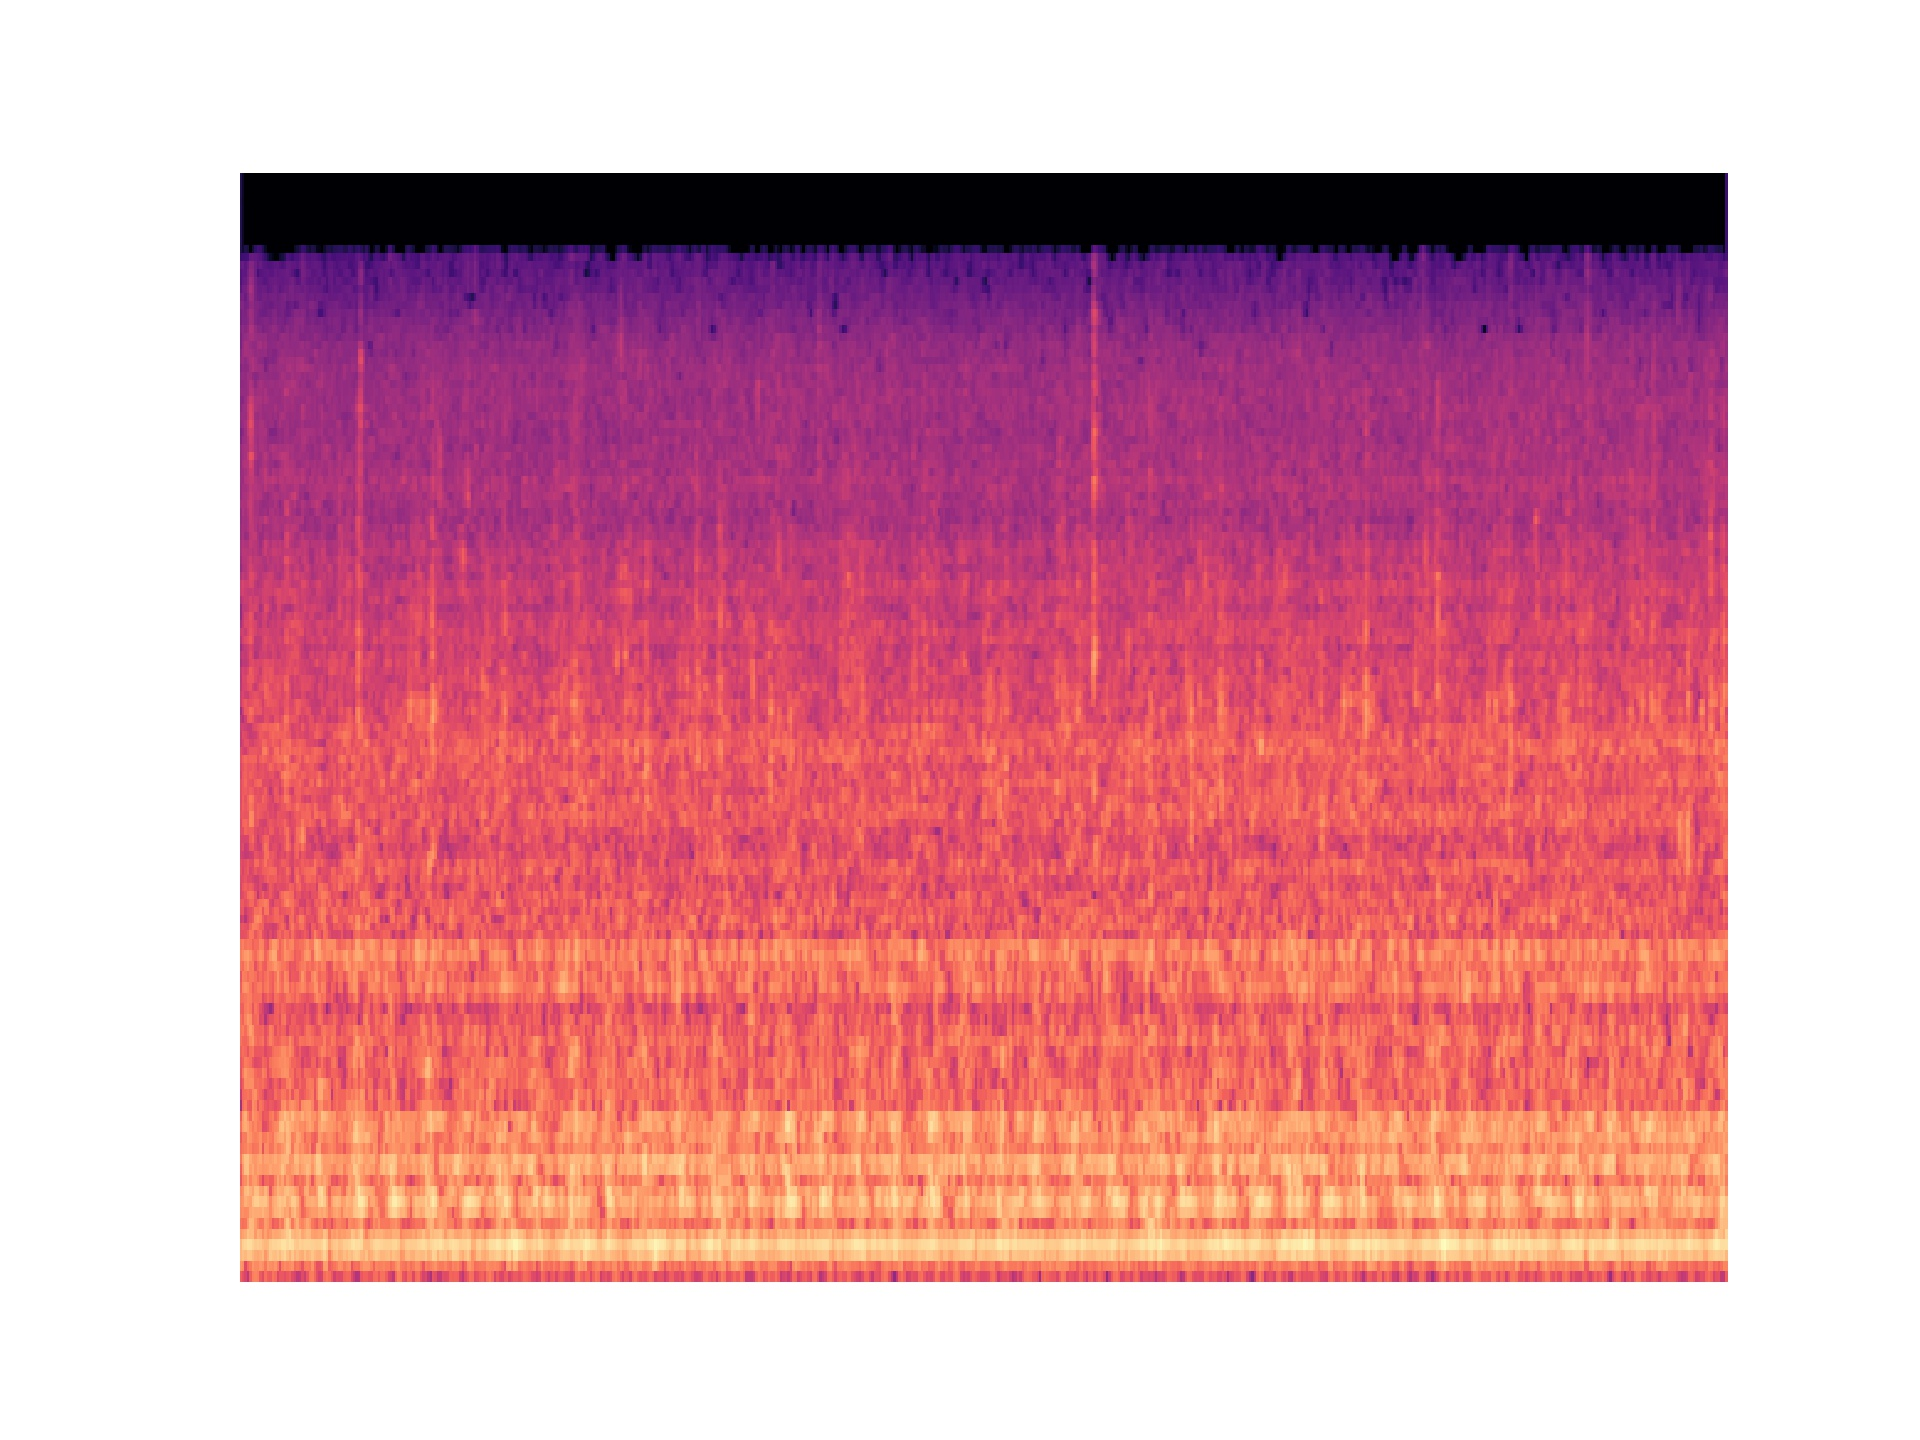

In [31]:
from IPython.display import Image
Image(filename=exportfile) 

In [32]:
print(emoji.emojize("Calling the custom vision model to predict sound anomalies :thumbs_up:"))
print()
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

with open(os.path.join (exportfile), "rb") as image_contents:
    results = predictor.classify_image(PROJECT_ID, ITERATION_NAME , image_contents.read())

    for prediction in results.predictions:
        print("\033[1;31;34m-", prediction.tag_name, "\tConfidence =", round(prediction.probability, 5))

Calling the custom vision model to predict sound anomalies 👍

- OK 	Confidence = 0.8365
- KO 	Confidence = 0.1635


In [33]:
listeprob=[]
listetag = []

for prediction in results.predictions:
    listetag.append(prediction.tag_name)
    listeprob.append(prediction.probability)

now = datetime.datetime.today()
print(now)

prob_max = max(listeprob)
max_index = listeprob.index(prob_max)
max_tag = listetag[max_index]
probapct = round(prob_max * 100, 2)
decision = max_tag.upper()

if max_tag == "KO":
    print("\033[1;31;91m")
    msg = "[ALERT] A sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

if max_tag == "OK":
    print("\033[1;31;34m")
    msg = "[OK] No sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

2022-05-31 09:07:57.737473

[OK] No sound anomaly has been detected with a confidence of 83.65%


In [34]:
gauge_report(prob_max, max_tag)

### So we are able to predict an anomaly using a CV model made with Azure Custom Vision

> You can run the next notebook

Note: All these Python notebooks were made for demo purposes. They were not designed for production usage. Some feature can be currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews. https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/